# テキストマイニングによる米国株価指数の予測  
デイリーのニュースから翌日の株価指数を予測してみる。  
元データはkaggleで公開されているものを使用。  
https://www.kaggle.com/aaron7sun/stocknews  

#### 市場データ  
ダウ・ジョーンズ工業株価平均（期間：2008/6/8〜2016/7/1）を使用。  
後述のとおり、デイリーの引け値の変化率を3クラスに分類し、クラス分類問題に帰着させる。

#### ニュースデータ
Reddit WorldNews Channelのデイリーニュースのヘッドラインを使用。  
https://www.reddit.com/r/worldnews/  
同サイトではユーザーの投票によりニュースがランク付けされる。  
本分析ではデイリーのtop25を元データとして使用。

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from xgboost import XGBClassifier, plot_importance
%matplotlib inline 

/home/fujiwara/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


必要な関数を定義

In [2]:
porter = PorterStemmer()
stop = stopwords.words('english')

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def getLabel(data):
    for d in data:
        if float(d) >= 0.01:
            yield 1
        elif float(d) <= -0.01:
            yield -1
        else:
            yield 0

def modifiedSentence(d):
    for _d in d:
        yield tokenizer_porter(_d)
        
def getSentence(d):
    for _d in d:
        res = ' '
        for t in _d:
            res = res + ' ' + t
        yield res

### 市場データの加工  
市場データをロード

In [3]:
mkt = pd.read_csv('DJIA_table.csv')
mkt.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


Dateを日付型に変換し、Indexにする

In [4]:
idx = pd.to_datetime(mkt['Date'])
mkt.index = idx
mkt.head()

,Date,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2016-07-01,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
2016-06-30,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2016-06-29,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
2016-06-28,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
2016-06-27,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


Adj Closeの日中変化率を求める

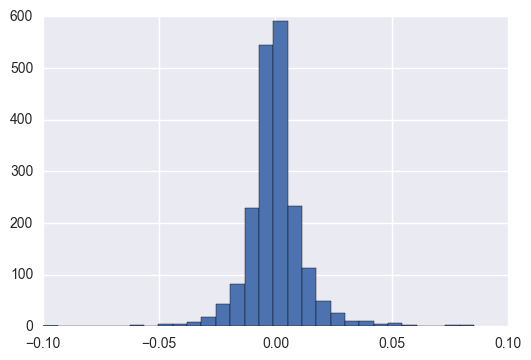

In [5]:
mkt['change'] = mkt['Adj Close'].pct_change()
mkt['change'].hist(bins=30)

変化率から以下のようにラベルを設定  
-1%以上下落→-1  
-1%〜1%→0  
1%以上上昇→1

In [6]:
mkt['Class'] = list(getLabel(mkt['change']))
mkt['Class'].value_counts()

 0    1441
-1     279
 1     269
Name: Class, dtype: int64

In [7]:
mkt.head(6)

,Date,Open,High,Low,Close,Volume,Adj Close,change,Class
Date,,,,,,,,,
2016-07-01,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,NaN,0
2016-06-30,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,-0.001080,0
2016-06-29,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,-0.013124,-1
2016-06-28,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,-0.016104,-1
2016-06-27,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-0.015479,-1
2016-06-24,2016-06-24,17946.630859,17946.630859,17356.339844,17400.750000,239000000,17400.750000,0.015199,1


### ニュースデータの加工  
ニュースデータのロード

In [8]:
news = pd.read_csv('RedditNews.csv')
idx2 = pd.to_datetime(news['Date'])
news.index = idx2
news = news.loc[idx, :] # ニュースの元データに休日分が含まれているため、インデックスを指定して削除
news.head()

,Date,News
Date,,
2016-07-01,2016-07-01,A 117-year-old woman in Mexico City finally re...
2016-07-01,2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,2016-07-01,"The president of France says if Brexit won, so..."
2016-07-01,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
2016-07-01,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


１日分のニュースを結合して１つにまとめる。  
翌日の株価を予測するので、日付を一つ先にずらす。

In [9]:
date = news.index.unique()
news_dict = {}
for i, d in enumerate(date):
    _n = ' '
    for n in news['News'][d]:
        _n = _n + ' ' + n.lower()
        news_dict[date[i-1]] = _n.replace("b'", "").replace('b"', '').replace("'", "")
            
news_dict = pd.DataFrame(news_dict, index = ['News'])
news_dict.head()

,2008-08-08 00:00:00,2008-08-11 00:00:00,2008-08-12 00:00:00,2008-08-13 00:00:00,2008-08-14 00:00:00,2008-08-15 00:00:00,2008-08-18 00:00:00,2008-08-19 00:00:00,2008-08-20 00:00:00,2008-08-21 00:00:00,...,2016-06-20 00:00:00,2016-06-21 00:00:00,2016-06-22 00:00:00,2016-06-23 00:00:00,2016-06-24 00:00:00,2016-06-27 00:00:00,2016-06-28 00:00:00,2016-06-29 00:00:00,2016-06-30 00:00:00,2016-07-01 00:00:00
News,a 117-year-old woman in mexico city finally ...,georgia downs two russian warplanes as count...,why wont america and nato help us? if they w...,remember that adorable 9-year-old who sang a...,u.s. refuses israel weapons to attack iran:...,all the experts admit that we should legalis...,mom of missing gay man: too bad hes not a 21...,"in an afghan prison, the majority of female ...",man arrested and locked up for five hours af...,two elderly chinese women have been sentence...,...,mp jo cox dead after shooting attack saudi a...,a staggering 87 percent of venezuelans say t...,an australian athlete who has competed in si...,german government agrees to ban fracking ind...,today the united kingdom decides whether to ...,david cameron to resign as pm after eu refer...,barclays and rbs shares suspended from tradi...,"2,500 scientists to australia: if you want t...",explosion at airport in istanbul yemeni form...,jamaica proposes marijuana dispensers for to...


生成したニュースデータの時制などを修正。

In [10]:
news_dict = news_dict.T
mf = modifiedSentence(news_dict['News'])
news_dict['Modified'] = list(getSentence(mf))
news_dict.head()

,News,Modified
2008-08-08,a 117-year-old woman in mexico city finally ...,a 117-year-old woman in mexico citi final re...
2008-08-11,georgia downs two russian warplanes as count...,georgia down two russian warplan as countri ...
2008-08-12,why wont america and nato help us? if they w...,whi wont america and nato help us? if they w...
2008-08-13,remember that adorable 9-year-old who sang a...,rememb that ador 9-year-old who sang at the ...
2008-08-14,u.s. refuses israel weapons to attack iran:...,u.s. refus israel weapon to attack iran: rep...


wordcloudで適当な日付のニュースを可視化してみる（全て下落率が高い日付）

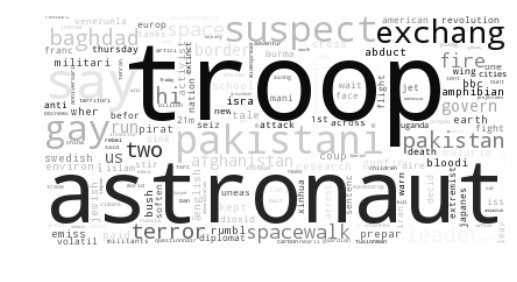

In [11]:
wc20080929 = WordCloud(background_color="white", colormap='binary', stopwords=stop).generate(news_dict['Modified']['2008-09-29'])
plt.imshow(wc20080929)
plt.axis("off")
plt.savefig('wc20080929.eps')

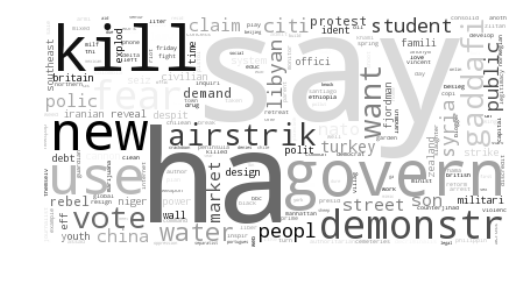

In [12]:
wc20110808 = WordCloud(background_color="white", colormap='binary', stopwords=stop).generate(news_dict['Modified']['2011-08-08'])
plt.imshow(wc20110808)
plt.axis("off")
plt.savefig('wc20110808.eps')

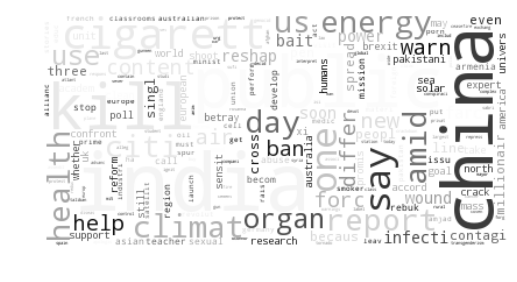

In [13]:
wc20160624 = WordCloud(background_color="white", colormap='binary', stopwords=stop).generate(news_dict['Modified']['2016-06-24'])
plt.imshow(wc20160624)
plt.axis("off")
plt.savefig('wc20160624.eps')

訓練データと検証データを分離する。  
mktとnews_dictを結合した後、2014/12/31以前を訓練データ、2015/1/1以降を検証データにする。  

In [14]:
data = pd.concat([news_dict['Modified'], mkt[['Class', 'Date', 'Adj Close', 'change']]], axis=1)

data = data[data['Date'] > '2008-08-08']
data.to_hdf('data.h5', key='data')

train = data[data['Date'] < '2015-01-01']
train.to_hdf('data.h5', key='train')

test = data[data['Date'] > '2014-12-31']
test.to_hdf('data.h5', key='test')

data.head()

,Modified,Class,Date,Adj Close,change
2008-08-11,georgia down two russian warplan as countri ...,1,2008-08-11,11782.349609,0.012015
2008-08-12,whi wont america and nato help us? if they w...,0,2008-08-12,11642.469727,0.009495
2008-08-13,rememb that ador 9-year-old who sang at the ...,0,2008-08-13,11532.959961,-0.007143
2008-08-14,u.s. refus israel weapon to attack iran: rep...,0,2008-08-14,11615.929688,-0.003771
2008-08-15,all the expert admit that we should legalis ...,1,2008-08-15,11659.900391,0.015725


単語を特徴ベクトルに変換する。  
CountVectorizerを使い、生の出現頻度をベクトル化

In [15]:
count = TfidfVectorizer(stop_words =stop)
doc = count.fit_transform(train['Modified'])
doc = doc.toarray()
doc = pd.DataFrame(doc, columns= count.get_feature_names(), index=train.index)
doc.head()

,00,000,000bpd,000ft,000new,000sq,001,004,00am,00pm,...,zubaydah,zuckberg,zuckerberg,zuckerburg,zulu,zuma,zurich,zuyevo,zweimal,zygi
2008-08-11,0.0,0.020066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-12,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-13,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-14,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-15,0.0,0.026485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


テスト用のデータもベクトルに変換しておく

In [16]:
doc_test = count.transform(test['Modified'])
doc_test = doc_test.toarray()
doc_test = pd.DataFrame(doc_test, columns= count.get_feature_names(), index=test.index)
doc_test.head()

,00,000,000bpd,000ft,000new,000sq,001,004,00am,00pm,...,zubaydah,zuckberg,zuckerberg,zuckerburg,zulu,zuma,zurich,zuyevo,zweimal,zygi
2015-01-02,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,0.0,0.044587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07,0.0,0.025625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-08,0.0,0.021938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


とりあえずXGBoostを使ってみる

In [17]:
xgb = XGBClassifier()
xgb.fit(doc, train['Class'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

特徴量の重要性をプロット（図が潰れて分からない・・・）

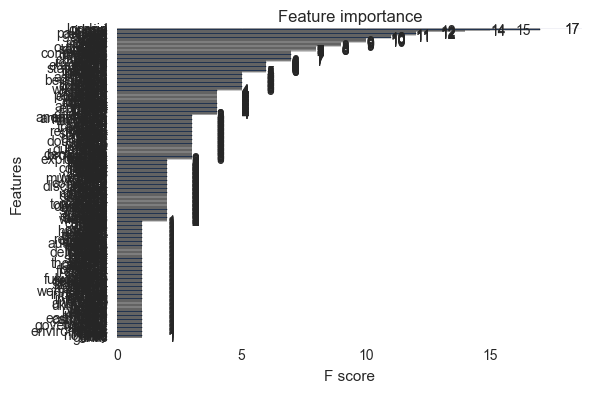

In [18]:
plot_importance(xgb)

F scoreが平均以上の変数を抽出  
最終的に入力次元は543次元になる

In [19]:
selectfrommodel = SelectFromModel(xgb, prefit=True)
doc_transformed = selectfrommodel.transform(doc)
doc_test_transformed = selectfrommodel.transform(doc_test)
doc_transformed.shape

(1610, 543)

In [20]:
doc_test_transformed.shape

(378, 543)

抽出された単語を確認（重要度の昇順で表示）  

In [21]:
feature_selected = {}
feature_selected['Name'] = doc.columns[selectfrommodel.get_support()]
feature_selected['importance'] = xgb.feature_importances_[selectfrommodel.get_support()]
feature_selected = pd.DataFrame(feature_selected)
feature_selected.to_csv('feature_selected.csv', index =False)
feature_selected.sort_values(by='importance', ascending=False)

,Name,importance
368,presid,0.010366
290,london,0.010366
118,crisi,0.009146
521,war,0.008537
280,land,0.008537
201,georgia,0.007317
268,israel,0.007317
540,year,0.007317
500,uk,0.007317
220,ha,0.007317


加工済みの訓練データと検証データをhdf形式で保存

In [22]:
train_selected = pd.DataFrame(doc_transformed, columns =feature_selected['Name'], index = train.index)
train_selected['Class'] = train['Class']
train_selected.to_hdf('data.h5', key='train_selected')

test_selected = pd.DataFrame(doc_test_transformed, columns =feature_selected['Name'], index = test.index)
test_selected['Class'] = test['Class']
test_selected.to_hdf('data.h5', key='test_selected')

train_selected.head()

Name,000,10,19,2007,25,30,300,49,50,77,...,women,work,worker,world,worsen,wtf,year,years,youth,Class
2008-08-11,0.020066,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.027571,0.000000,0.032530,0.0,0.0,0.015689,0.033121,0.0,1
2008-08-12,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.037014,0.000000,0.021836,0.0,0.0,0.000000,0.000000,0.0,0
2008-08-13,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026138,0.000000,0.000000,0.017475,0.0,0.0,0.033711,0.000000,0.0,0
2008-08-14,0.000000,0.034076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.018850,0.000000,0.0,0
2008-08-15,0.026485,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.040475,0.042935,0.0,0.0,0.020707,0.000000,0.0,1


In [23]:
test_selected.head()

Name,000,10,19,2007,25,30,300,49,50,77,...,women,work,worker,world,worsen,wtf,year,years,youth,Class
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.047943,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.019892,0.0,0.0,0.019187,0.0,0.000000,1
2015-01-05,0.044587,0.000000,0.000000,0.000000,0.0,0.036205,0.000000,0.0,0.037853,0.0,...,0.0,0.000000,0.0,0.018071,0.0,0.0,0.122013,0.0,0.048725,0
2015-01-06,0.000000,0.000000,0.053686,0.061897,0.0,0.000000,0.000000,0.0,0.039298,0.0,...,0.0,0.000000,0.0,0.056281,0.0,0.0,0.000000,0.0,0.000000,-1
2015-01-07,0.025625,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.043510,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1
2015-01-08,0.021938,0.062016,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.030143,0.0,0.017783,0.0,0.0,0.034305,0.0,0.000000,0


#### 別途グリッドサーチを行ったXGBモデルをロードし、精度を検証  
2017/8/17　とりあえず前回のグリッドサーチでベストだったハイパーパラメータを使用  
モデルをロード

In [24]:
xgb = joblib.load('xgb.pkl')
xgb.fit(doc_transformed, train['Class'])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=100,
       min_child_weight=1.0, missing=nan, n_estimators=10, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

実データとモデルによる予測値を保存

In [25]:
predict_t = {}
predict_t['Model']=xgb.predict(doc_test_transformed)
predict_t['Act'] = test['Class']
predict_t = pd.DataFrame(predict_t, index = test.index)
predict_t.to_csv('predict_t.csv')
predict_t.head()

,Act,Model
2015-01-02,1,0
2015-01-05,0,0
2015-01-06,-1,1
2015-01-07,-1,0
2015-01-08,0,0


各クラスの予測精度を算出  
全体の正解率は7割程度だが、ラベルが-1or1の正解率が低い・・・

In [26]:
accuracy_score(test['Class'], predict_t['Model'])

0.69841269841269837

In [27]:
precision_score(test['Class'], predict_t['Model'], average=None)

array([ 0.25      ,  0.71703297,  0.16666667])

In [28]:
recall_score(test['Class'], predict_t['Model'], average=None)

array([ 0.03508772,  0.97752809,  0.01851852])